In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np

# Check if MPS (Metal Performance Shaders) is available (for M1 Macs)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 1. Data Preprocessing
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to (-1, 1)
])

# Download and load the dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split full_train_dataset into training (50k), validation (10k), and test (10k) sets
train_dataset = Subset(full_train_dataset, range(0, 50000))
val_dataset = Subset(full_train_dataset, range(50000, 60000))

# Define the model
class MLRModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLRModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        
    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [3]:
# Part 2: Minibatch Training
batch_sizes = [1, 10, 100, 1000]
num_epochs = 20
ce_loss_vs_iteration = {}
ce_loss_vs_epoch = {}
lowest_loss_per_batchsize = {}
epochs_to_lowest_loss = {}
val_losses_per_batchsize = {}
lowest_val_loss_per_batchsize = {}
epochs_to_lowest_val_loss = {}

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    # Initialize the model
    input_dim = 28 * 28
    num_classes = 10
    model = MLRModel(input_dim, num_classes).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    # Training
    total_steps = len(train_loader)
    ce_loss_list = []
    ce_loss_epoch_list = []
    val_loss_epoch_list = []
    iteration = 0
    lowest_loss = float('inf')
    epoch_of_lowest_loss = 0
    lowest_val_loss = float('inf')
    epoch_of_lowest_val_loss = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train_loss = 0.0
        total_train_samples = 0
        for i, (images, labels) in enumerate(train_loader):
            # Flatten images
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accumulate losses
            running_loss += loss.item()
            batch_size_curr = images.size(0)
            total_train_loss += loss.item() * batch_size_curr
            total_train_samples += batch_size_curr
            iteration += 1
            # Compute CE loss every 5000 / batch_size iterations (10 times per epoch)
            if (i + 1) % max(1, total_steps // 10) == 0:
                avg_loss = running_loss / max(1, total_steps // 10)
                ce_loss_list.append(avg_loss)
                running_loss = 0.0
        # Compute average training loss at the end of each epoch
        average_epoch_loss = total_train_loss / total_train_samples
        ce_loss_epoch_list.append(average_epoch_loss)
        # Validation loss computation
        model.eval()
        total_val_loss = 0.0
        total_val_samples = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                batch_size_curr = images.size(0)
                total_val_loss += loss.item() * batch_size_curr
                total_val_samples += batch_size_curr
        average_val_loss = total_val_loss / total_val_samples
        val_loss_epoch_list.append(average_val_loss)
        # Check for lowest training loss
        if ce_loss_epoch_list[-1] < lowest_loss:
            lowest_loss = ce_loss_epoch_list[-1]
            epoch_of_lowest_loss = epoch + 1
        # Check for lowest validation loss
        if val_loss_epoch_list[-1] < lowest_val_loss:
            lowest_val_loss = val_loss_epoch_list[-1]
            epoch_of_lowest_val_loss = epoch + 1
        # Update after each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_epoch_loss:.4f}, Validation Loss: {average_val_loss:.4f}")
    # Store results
    ce_loss_vs_iteration[batch_size] = ce_loss_list
    ce_loss_vs_epoch[batch_size] = ce_loss_epoch_list
    lowest_loss_per_batchsize[batch_size] = lowest_loss
    epochs_to_lowest_loss[batch_size] = epoch_of_lowest_loss
    val_losses_per_batchsize[batch_size] = val_loss_epoch_list
    lowest_val_loss_per_batchsize[batch_size] = lowest_val_loss
    epochs_to_lowest_val_loss[batch_size] = epoch_of_lowest_val_loss


Training with batch size: 1
Epoch [1/20], Training Loss: 0.8518, Validation Loss: 0.7009
Epoch [2/20], Training Loss: 0.7831, Validation Loss: 0.8089
Epoch [3/20], Training Loss: 0.7707, Validation Loss: 1.2503
Epoch [4/20], Training Loss: 0.7529, Validation Loss: 0.9037
Epoch [5/20], Training Loss: 0.7552, Validation Loss: 0.6159
Epoch [6/20], Training Loss: 0.7310, Validation Loss: 0.9568
Epoch [7/20], Training Loss: 0.7362, Validation Loss: 0.9090
Epoch [8/20], Training Loss: 0.7252, Validation Loss: 0.7042
Epoch [9/20], Training Loss: 0.7235, Validation Loss: 0.6986
Epoch [10/20], Training Loss: 0.7202, Validation Loss: 0.7553
Epoch [11/20], Training Loss: 0.7172, Validation Loss: 0.6882
Epoch [12/20], Training Loss: 0.7113, Validation Loss: 1.2273
Epoch [13/20], Training Loss: 0.7177, Validation Loss: 0.6286
Epoch [14/20], Training Loss: 0.7087, Validation Loss: 0.6581
Epoch [15/20], Training Loss: 0.7110, Validation Loss: 0.6485
Epoch [16/20], Training Loss: 0.7044, Validation L

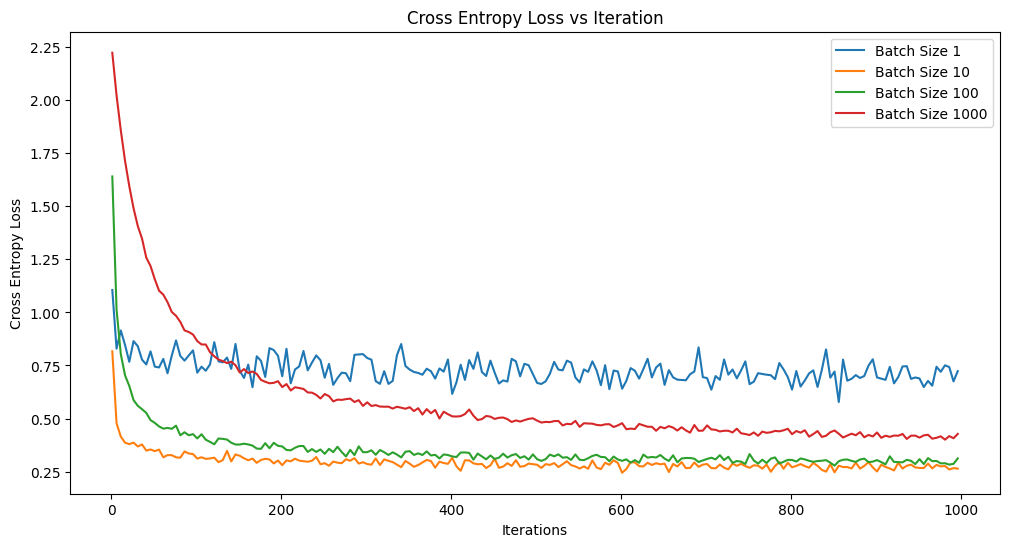

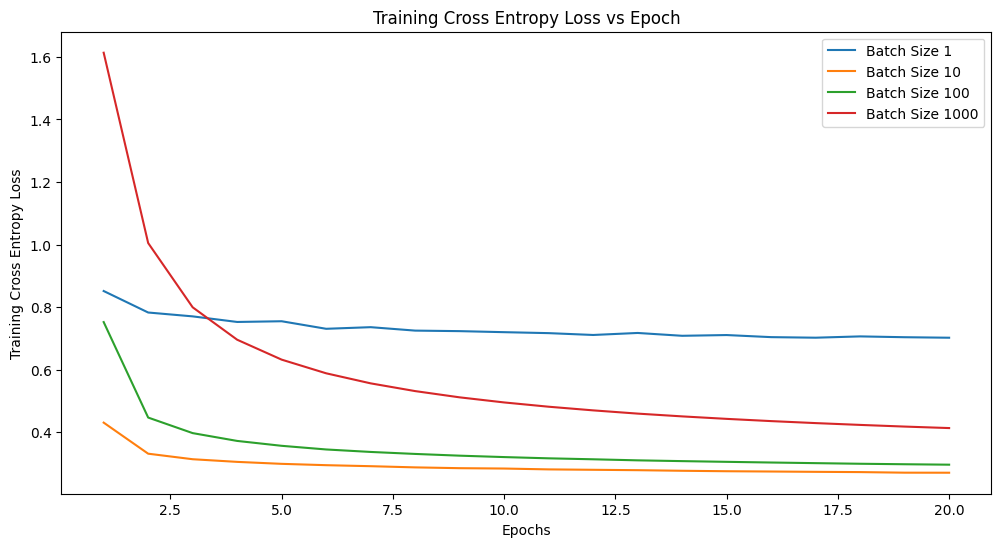

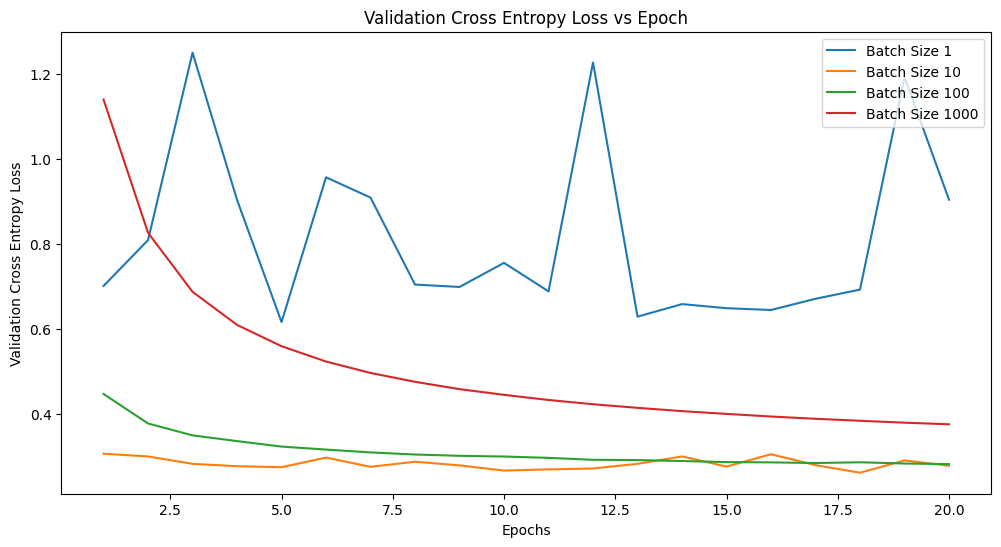

In [4]:
# 2(b) Plot CE loss vs iteration
import math

# Plot CE loss vs iteration
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    total_iterations = len(train_loader) * num_epochs
    interval = max(1, len(train_loader) // 10)
    iterations = np.arange(len(ce_loss_vs_iteration[batch_size])) * interval + 1
    plt.plot(iterations, ce_loss_vs_iteration[batch_size], label=f'Batch Size {batch_size}')
plt.title('Cross Entropy Loss vs Iteration')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

# Plot CE loss vs epoch (Training Loss)
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(range(1, num_epochs + 1), ce_loss_vs_epoch[batch_size], label=f'Batch Size {batch_size}')
plt.title('Training Cross Entropy Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Training Cross Entropy Loss')
plt.legend()
plt.show()

# Plot Validation Loss vs Epoch
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(range(1, num_epochs + 1), val_losses_per_batchsize[batch_size], label=f'Batch Size {batch_size}')
plt.title('Validation Cross Entropy Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Cross Entropy Loss')
plt.legend()
plt.show()

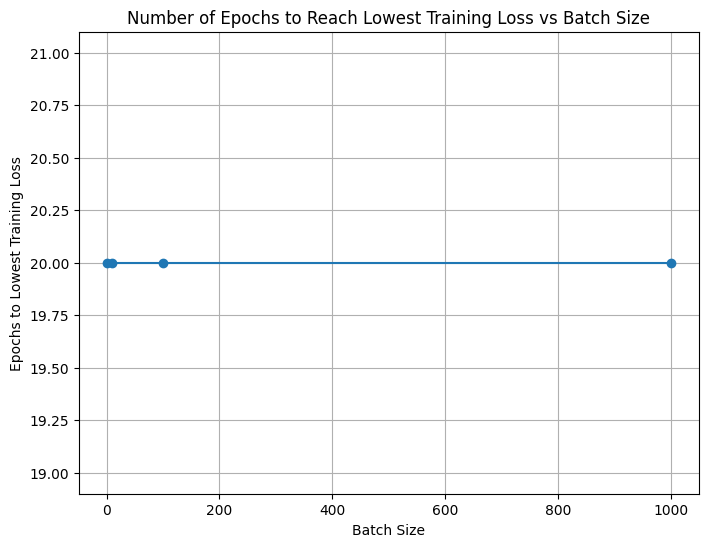

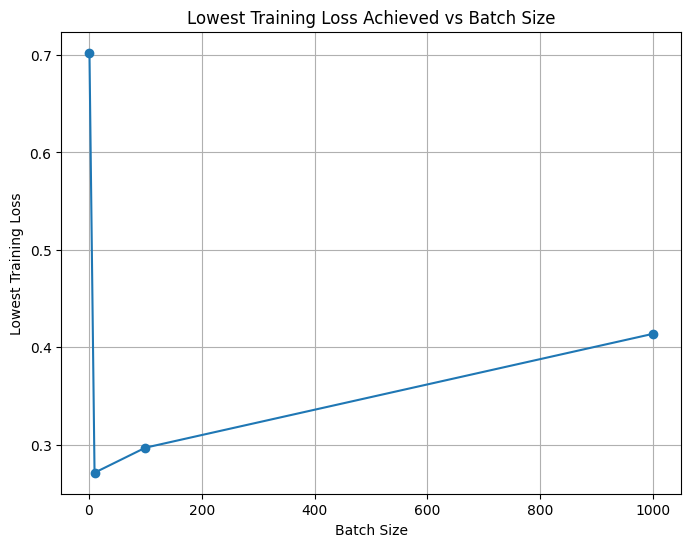

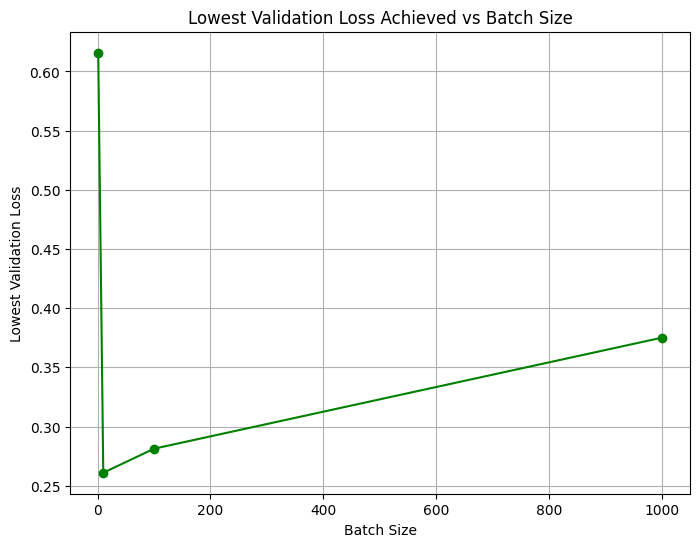

Best batch size based on validation loss: 10


In [5]:
# 2(c) Plot number of epochs to reach lowest loss and lowest training loss vs batch size
batch_sizes_array = np.array(batch_sizes)

# Plot number of epochs to reach lowest training loss vs batch size
epochs_needed = [epochs_to_lowest_loss[bs] for bs in batch_sizes]
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_array, epochs_needed, marker='o')
plt.title('Number of Epochs to Reach Lowest Training Loss vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Epochs to Lowest Training Loss')
plt.grid(True)
plt.show()

# Plot lowest training loss achieved vs batch size
lowest_losses = [lowest_loss_per_batchsize[bs] for bs in batch_sizes]
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_array, lowest_losses, marker='o')
plt.title('Lowest Training Loss Achieved vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Lowest Training Loss')
plt.grid(True)
plt.show()

# Plot lowest validation loss achieved vs batch size
lowest_val_losses = [lowest_val_loss_per_batchsize[bs] for bs in batch_sizes]
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_array, lowest_val_losses, marker='o', color='green')
plt.title('Lowest Validation Loss Achieved vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Lowest Validation Loss')
plt.grid(True)
plt.show()

# Determine the best batch size based on validation loss
best_batch_size = min(lowest_val_loss_per_batchsize, key=lowest_val_loss_per_batchsize.get)
print(f"Best batch size based on validation loss: {best_batch_size}")


Training with weight decay (λ) = 0
Epoch [1/20], Training Loss: 0.4309, Validation Loss: 0.3418
Epoch [2/20], Training Loss: 0.3315, Validation Loss: 0.2963
Epoch [3/20], Training Loss: 0.3157, Validation Loss: 0.2989
Epoch [4/20], Training Loss: 0.3051, Validation Loss: 0.2839
Epoch [5/20], Training Loss: 0.2990, Validation Loss: 0.2871
Epoch [6/20], Training Loss: 0.2948, Validation Loss: 0.2784
Epoch [7/20], Training Loss: 0.2919, Validation Loss: 0.2838
Epoch [8/20], Training Loss: 0.2877, Validation Loss: 0.2730
Epoch [9/20], Training Loss: 0.2853, Validation Loss: 0.2730
Epoch [10/20], Training Loss: 0.2844, Validation Loss: 0.2742
Epoch [11/20], Training Loss: 0.2818, Validation Loss: 0.2858
Epoch [12/20], Training Loss: 0.2807, Validation Loss: 0.2762
Epoch [13/20], Training Loss: 0.2781, Validation Loss: 0.2704
Epoch [14/20], Training Loss: 0.2768, Validation Loss: 0.2707
Epoch [15/20], Training Loss: 0.2763, Validation Loss: 0.2795
Epoch [16/20], Training Loss: 0.2747, Valid

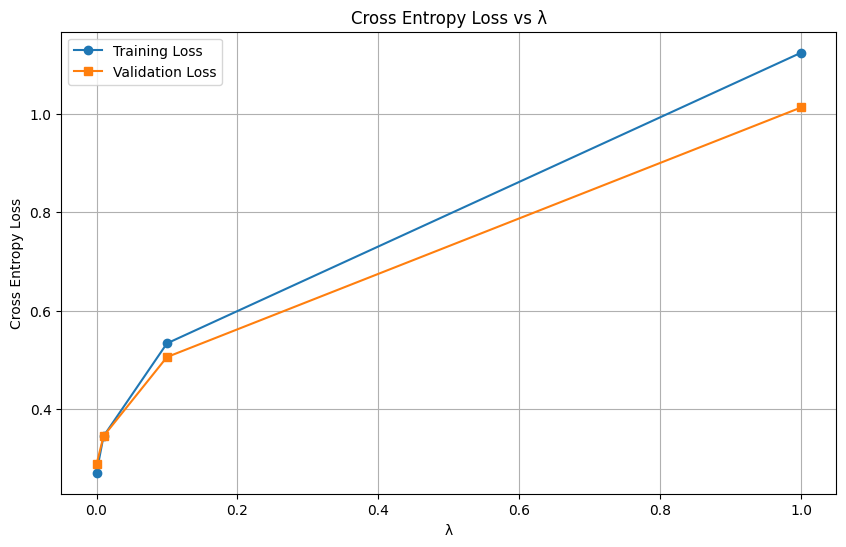

In [6]:
# Part 3: Weight Decay Experiment
# Using the best batch size from Part 2
batch_size = best_batch_size
num_epochs = 20
lambdas = [0, 0.01, 0.1, 1]
train_losses = {}
val_losses = {}
weight_norms = {}

for lam in lambdas:
    print(f"\nTraining with weight decay (λ) = {lam}")
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    # Initialize the model
    input_dim = 28 * 28
    num_classes = 10
    model = MLRModel(input_dim, num_classes).to(device)
    # Loss and optimizer with weight decay (L2 regularization)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=lam)
    # Training
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0
        total_train_samples = 0
        for images, labels in train_loader:
            # Flatten images
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accumulate training loss
            batch_size_curr = images.size(0)
            total_train_loss += loss.item() * batch_size_curr
            total_train_samples += batch_size_curr
        average_train_loss = total_train_loss / total_train_samples

        # Validation
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0.0
        total_val_samples = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                batch_size_curr = images.size(0)
                total_val_loss += loss.item() * batch_size_curr
                total_val_samples += batch_size_curr
        average_val_loss = total_val_loss / total_val_samples

        # Update after each epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")
    
    # Store the final epoch losses
    train_losses[lam] = average_train_loss
    val_losses[lam] = average_val_loss
    # Compute ||w||^2
    with torch.no_grad():
        w_norm = 0.0
        for param in model.parameters():
            w_norm += torch.sum(param.data ** 2).item()
        weight_norms[lam] = w_norm

# Plot CE loss on training and validation sets vs λ (without log scale)
plt.figure(figsize=(10, 6))
plt.plot(lambdas, [train_losses[lam] for lam in lambdas], marker='o', label='Training Loss')
plt.plot(lambdas, [val_losses[lam] for lam in lambdas], marker='s', label='Validation Loss')
plt.title('Cross Entropy Loss vs λ')
plt.xlabel('λ')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot ||w||^2 vs λ (without log scale)
plt.figure(figsize=(10, 6))
plt.plot(lambdas, [weight_norms[lam] for lam in lambdas], marker='o')
plt.title('||w||^2 vs λ')
plt.xlabel('λ')
plt.ylabel('||w||^2')
plt.grid(True)
plt.show()

Epoch [1/20], Test Loss: 0.3429
Epoch [2/20], Test Loss: 0.3363
Epoch [3/20], Test Loss: 0.3290
Epoch [4/20], Test Loss: 0.3431
Epoch [5/20], Test Loss: 0.3178
Epoch [6/20], Test Loss: 0.3262
Epoch [7/20], Test Loss: 0.3259
Epoch [8/20], Test Loss: 0.3399
Epoch [9/20], Test Loss: 0.3239
Epoch [10/20], Test Loss: 0.3446
Epoch [11/20], Test Loss: 0.3197
Epoch [12/20], Test Loss: 0.3232
Epoch [13/20], Test Loss: 0.3290
Epoch [14/20], Test Loss: 0.3266
Epoch [15/20], Test Loss: 0.3469
Epoch [16/20], Test Loss: 0.3259
Epoch [17/20], Test Loss: 0.3416
Epoch [18/20], Test Loss: 0.3302
Epoch [19/20], Test Loss: 0.3318
Epoch [20/20], Test Loss: 0.3218


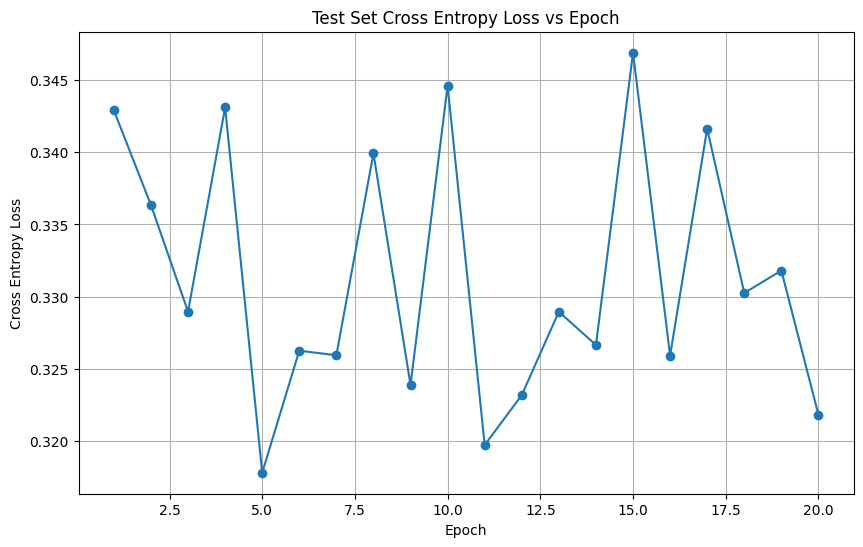

In [11]:
# Select the best λ based on validation loss
# best_lambda = min(val_losses, key=val_losses.get)
# print(f"Best λ based on validation loss: {best_lambda}")

best_lambda = 0.01 # From Observations
batch_size = 10 # From previous experiments
num_epochs = 20
criterion = nn.CrossEntropyLoss()

# Train on the combined training data (train + validation sets) using the best λ
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model

input_dim = 28 * 28
num_classes = 10
model = MLRModel(input_dim, num_classes).to(device)
# Loss and optimizer with best λ
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=best_lambda)

# Training on combined data and computing test loss per epoch
test_losses = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for images, labels in combined_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute test loss at the end of each epoch
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0.0
    total_test_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            batch_size_curr = images.size(0)
            total_test_loss += loss.item() * batch_size_curr
            total_test_samples += batch_size_curr
    average_test_loss = total_test_loss / total_test_samples
    test_losses.append(average_test_loss)
    # Update after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {average_test_loss:.4f}")

# Plot testing loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), test_losses, marker='o')
plt.title('Test Set Cross Entropy Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True)
plt.show()